In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, 'code')

In [3]:
import json
import random
import pickle
import argparse
import functools
from collections import Counter

import nltk
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_sequence

from tqdm import tqdm

import pandas
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap


from IPython.core.display import display # , Image

# from dataset import CLEVR, collate_data, transform
# from model import MACNetwork
# from config import cfg

# ## Load Data from Disc

# from PIL import Image as PILImage

sns.set()
matplotlib.rcParams['figure.figsize'] = [10, 10]

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [133]:
# -*- coding: utf-8 -*-
# ## Import dependencies

split = 'val'


def get_im_features(impath):
    img = PILImage.open(impath).convert('RGB')
    img = transform(img)
    img = img.to(device).unsqueeze(0)
    features = resnet(img).detach()
    return features


def get_tokenized_question(question):
    words = nltk.word_tokenize(question['question'])
    question_token = []
    for word in words:
        question_token.append(word_dic[word])
    return torch.tensor(question_token).unsqueeze(0)


# +
# plotting
imageDims = (14, 14)
figureImageDims = (2, 3)
figureTableDims = (5, 4)
fontScale = 1

# set transparent mask for low attention areas
# cdict = plt.get_cmap("gnuplot2")._segmentdata
cdict = {
    "red": ((0.0, 0.0, 0.0), (0.6, 0.8, 0.8), (1.0, 1, 1)),
    "green": ((0.0, 0.0, 0.0), (0.6, 0.8, 0.8), (1.0, 1, 1)),
    "blue": ((0.0, 0.0, 0.0), (0.6, 0.8, 0.8), (1.0, 1, 1))
}
cdict["alpha"] = ((0.0, 0.35, 0.35), (1.0, 0.65, 0.65))
plt.register_cmap(name="custom", data=cdict)
# -

# if cfg.MAC.USE_ACT and cfg.ACT.SMOOTH:
#    for ans, halt in zip(atts['ans'][-1], atts['halts'][-1]):
#        correct = ans.argmax()
#        print("Answered: {}, Correct: {}".format(
#            reverse_answer_dic[correct.item()], question['answer']))
#        print(halt)


# ### Visualizing Question Atts

def showTableAtt(table, words, tax=None):
    '''
    Question attention as sns heatmap
    '''
    if tax is None:
        fig2, bx = plt.subplots(1, 1)
        bx.cla()
    else:
        bx = tax

    sns.set(font_scale=fontScale)

    steps = len(table)

    # traspose table
    table = np.transpose(table)

    tableMap = pandas.DataFrame(data=table,
                                columns=[i for i in range(1, steps + 1)],
                                index=words)

    bx = sns.heatmap(tableMap,
                     cmap="Purples",
                     cbar=True,
                     linewidths=.5,
                     linecolor="gray",
                     square=True,
                     # ax=bx,
                    )

    # # x ticks
    bx.xaxis.tick_top()
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    # y ticks
    locs, labels = plt.yticks()
    plt.setp(labels, rotation=0)


# table = np.array(atts['question'][-1])

# questionList = nltk.word_tokenize(question['question'])
# showTableAtt(table, questionList)


# ### Visualizing Image Atts

def showImgAtt(img, atts, step, ax):
    dx, dy = 0.05, 0.05
    x = np.arange(-1.5, 1.5, dx)
    y = np.arange(-1.0, 1.0, dy)
    X, Y = np.meshgrid(x, y)
    extent = np.min(x), np.max(x), np.min(y), np.max(y)

    ax.cla()

    if dataset == 'clevr':
        imageDims = (14, 14)
    else:
        imageDims = (7, 7)
    
    img1 = ax.imshow(img, interpolation="nearest", extent=extent)
    ax.imshow(np.array(atts[step]).reshape(imageDims),
              cmap=plt.get_cmap('custom'),
              interpolation="bicubic",
              extent=extent,
              
             )

    ax.set_axis_off()
    plt.axis("off")

    ax.set_aspect("auto")


def showImgAtts(atts, impath):
    img = imread(impath)

    length = len(atts)

    # show images
    for j in range(length):
        fig, ax = plt.subplots()
        fig.set_figheight(figureImageDims[0])
        fig.set_figwidth(figureImageDims[1])

        showImgAtt(img, atts, j, ax)

        plt.subplots_adjust(bottom=0, top=1, left=0, right=1)

In [6]:
# 
from collections import OrderedDict


def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)

# using wonder's beautiful simplification: https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects/31174427?noredirect=1#comment86638618_31174427

def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

class IntermediateLayerGetter(nn.Module):
    def __init__(self, model, return_layers, keep_output=True):
        super().__init__()
        self._model = model
        self.return_layers = return_layers
        self.keep_output = keep_output
        
    def forward(self, *args, **kwargs):
        ret = OrderedDict()
        handles = []
        for name, new_name in self.return_layers.items():
            layer = rgetattr(self._model, name)
            
            def hook(module, input, output, new_name=new_name):
                if new_name in ret:
                    if type(ret[new_name]) is list:
                        ret[new_name].append(output)
                    else:
                        ret[new_name] = [ret[new_name], output]
                else:
                    ret[new_name] = output
            h = layer.register_forward_hook(hook)
            handles.append(h)
            
        if self.keep_output:
            output = self._model(*args, **kwargs)
        else:
            self._model(*args, **kwargs)
            output = None
            
        for h in handles:
            h.remove()
        
        return ret, output

In [7]:
from easydict import EasyDict as edict

from mac import MACNetwork
from utils import load_vocab
from datasets import ClevrDataset, collate_fn
# from datasets import ClevrScenesDataset, scenes_collate_fn

import json
import numpy as np

from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

import nltk
import pandas as pd

import math
import matplotlib.gridspec as gridspec

In [8]:
dataset_root = '/storage1/datasets/GQA/data'

In [9]:
from easydict import EasyDict as edict

import yaml
from config import __C, _merge_a_into_b 

In [11]:
cfg_file = '/home/samenabar/code/filmac/FiLMac/cfg/nb1_clevr.yml'

with open(cfg_file, 'r') as f:
    yaml_cfg = edict(yaml.safe_load(f))
_merge_a_into_b(yaml_cfg, __C)

In [13]:
from datasets import ClevrDataset, collate_fn, GQADataset, collate_fn_gqa

In [89]:
split = 'val'
dataset = 'gqa'


if dataset == 'clevr':
    clevr_dir = '/storage1/datasets/CLEVR_v1.0/'
    __C.DATASET.DATA_DIR = '/storage1/datasets/CLEVR_v1.0/features'
    ds = ClevrDataset(
        data_dir=__C.DATASET.DATA_DIR,
        split=split,
        sample=False,
    )
    with open(os.path.join(clevr_dir, 'questions', f'CLEVR_{split}_questions.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
else:
    __C.DATASET.DATA_DIR = '/storage1/datasets/GQA/data'
    ds = GQADataset(
        data_dir=__C.DATASET.DATA_DIR,
        split=split,
        sample=False,
    )

    with open(os.path.join(dataset_root, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
vocab = load_vocab(__C)

# word_dic, answer_dic = vocab['word_dic'], vocab['answer_dic']
# reverse_word_dic = {word_dic[key]: key for key in word_dic}
# reverse_answer_dic = {answer_dic[key]: key for key in answer_dic}

reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']

In [39]:
model = MACNetwork(__C, vocab)
state = torch.load('/home/samenabar/code/filmac/FiLMac/data/nb1_clevr/Model/model_checkpoint_000010.pth', map_location='cpu')
model.load_state_dict(state['model'])
model.eval()

return_layers = {
    'mac.control.cw_attn_idty': 'cw_attn',
    'mac.read.kb_attn_idty': 'kb_attn',
    'mac.read.beta_idty': 'betas',
    'mac.read.gamma_idty': 'gammas',
}
mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

In [137]:
def setlabel(ax, label, loc=2, borderpad=0.6, **kwargs):
    legend = ax.get_legend()
    if legend:
        ax.add_artist(legend)
    line, = ax.plot(np.NaN,np.NaN,color='none',label=label)
    label_legend = ax.legend(
        handles=[line],
        loc=loc,
        handlelength=0,
        handleheight=0,
        handletextpad=0,
        borderaxespad=0,
        borderpad=borderpad,
        frameon=False,
        prop={
         'size': 18,
         'weight': 'bold',
        },
        **kwargs,
    )
    label_legend.remove()
    ax.add_artist(label_legend)
    line.remove()
    
def get_image(q_index, split, ds):
    if dataset == 'clevr':
        image_filename = ds.questions[q_index]['image_filename']
        image = Image.open(os.path.join(__C.DATASET.DATA_DIR.strip('features'), 'images', split, image_filename)).convert('RGB')

    elif dataset == 'gqa':
        image_filename = ds.questions[q_index]['imageId'] + '.jpg'
        image = Image.open(os.path.join(__C.DATASET.DATA_DIR.strip('data'), 'images', image_filename)).convert('RGB')

    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(0.5)
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)
        
    
    return image

In [157]:
def plot_word_img_attn(mid_outputs, q_index, split, ds, num_steps):
    # fig = plt.figure(figsize=(num_steps, 16))
    fig = plt.figure(figsize=(16, num_steps * 2))
    
    g0 = gridspec.GridSpec(num_steps // 2, 3, figure=fig)
    
    ax_table = fig.add_subplot(g0[:, 0])
    ax_images = []
    for i in range(num_steps // 2):
        ax_images.append(fig.add_subplot(g0[i, 1]))
        ax_images.append(fig.add_subplot(g0[i, 2]))
    
    table = np.array([t.numpy()[0].squeeze(-1) for t in mid_outputs['cw_attn']])
    steps = len(table)
    table = np.transpose(table)

    half = math.ceil(len(table) / 2)
    words = nltk.word_tokenize(ds.questions[q_index]['question'])

    tableMap = pandas.DataFrame(data=table,
                                columns=[i for i in range(1, steps + 1)],
                                index=words)

    bx = sns.heatmap(tableMap,
                     cmap="Purples",
                     cbar=True,
                     linewidths=.5,
                     linecolor="gray",
                     square=True,
                     ax=ax_table,
                    )
    bx.set_ylim(bx.get_ylim()[0] + 0.5, bx.get_ylim()[1] - 0.5)
    
    for i in range(num_steps):
        ax = ax_images[i]
        showImgAtt(get_image(q_index, split, ds), mid_outputs['kb_attn'], i, ax)
        setlabel(ax, str(i + 1))

    plt.tight_layout()
    plt.show()

In [55]:
import numpy as np
import matplotlib.pyplot as plt

In [62]:
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader

In [67]:
model = model.cuda()

In [70]:
loader = DataLoader(ds, num_workers=1, batch_size=512, collate_fn=collate_fn, shuffle=True)

all_gammas = []
all_betas = []
for i, b in tqdm(enumerate(loader), total=len(loader)):
    with torch.no_grad():
        mid_outputs, _ = mid_getter(b['image'].cuda(), b['question'].cuda(), b['question_length'])
        
    all_gammas.append(torch.cat(mid_outputs['gammas']).cpu().numpy())
    all_betas.append(torch.cat(mid_outputs['betas']).cpu().numpy())

    
    if i >= 100:
        break     

/home/samenabar/.venvs/cuda10/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

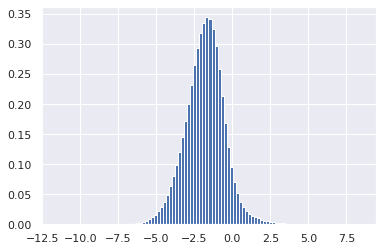

In [87]:
plt.hist(np.concatenate(all_betas).flatten(), bins=100, density=True);

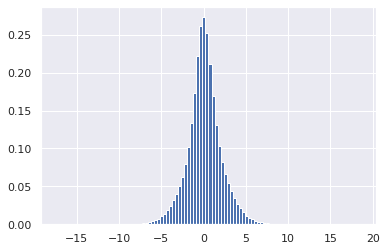

In [88]:
plt.hist(np.concatenate(all_gammas).flatten(), bins=100, density=True);

In [100]:
del __C
from config import __C, _merge_a_into_b 

In [119]:
cfg_file = '/home/samenabar/code/filmac/FiLMac/data/nb1_gqa/nb1_gqa.yml'

with open(cfg_file, 'r') as f:
    yaml_cfg = edict(yaml.safe_load(f))
_merge_a_into_b(yaml_cfg, __C)

# __C.model.common.module_dim = 512
# __C.model.input_unit.rnn_dim = 512

split = 'val'
dataset = 'gqa'

if dataset == 'clevr':
    clevr_dir = '/storage1/datasets/CLEVR_v1.0/'
    __C.DATASET.DATA_DIR = '/storage1/datasets/CLEVR_v1.0/features'
    ds = ClevrDataset(
        data_dir=__C.DATASET.DATA_DIR,
        split=split,
        sample=False,
    )
    with open(os.path.join(clevr_dir, 'questions', f'CLEVR_{split}_questions.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
else:
    __C.DATASET.DATA_DIR = '/storage1/datasets/GQA/data'
    ds = GQADataset(
        data_dir=__C.DATASET.DATA_DIR,
        split=split,
        sample=False,
    )

    with open(os.path.join(dataset_root, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
vocab = load_vocab(__C)

reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']

model = MACNetwork(__C, vocab, num_answers=len(vocab['answer_token_to_idx']))
state = torch.load('/home/samenabar/code/filmac/FiLMac/data/nb1_gqa/Model/model_checkpoint_000040.pth', map_location='cpu')
model.load_state_dict(state['model'])
model.eval()

return_layers = {
    'mac.control.cw_attn_idty': 'cw_attn',
    'mac.read.kb_attn_idty': 'kb_attn',
    'mac.read.beta_idty': 'betas',
    'mac.read.gamma_idty': 'gammas',
}
mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

In [121]:
ds.questions[200]

{'questionId': '0054370',
 'group': 'categoryRelO',
 'answer': 'horse',
 'type': 'query',
 'fullAnswer': 'The man stands beside the horse.',
 'question': 'What animal does the man stand beside of?',
 'imageId': '2342333'}

In [170]:
import os

In [172]:
files = os.listdir('/storage1/datasets/GQA/images/')

In [174]:
ids = [f.strip('.jpg') for f in files]

In [176]:
len(ids)

47038

In [177]:
ids2 = [q['imageId'] for q in ds.questions]

In [179]:
np.intersect1d(ids, ids2)

array(['1016', '1058', '107905', ..., '912', '930', '961'], dtype='<U7')

In [180]:
for i, q in enumerate(ds.questions):
    if q['imageId'] == '1016':
        print(i, q)
        # break

121488 {'questionId': '18315440', 'group': 'verifyAttrs', 'answer': 'yes', 'type': 'logical', 'fullAnswer': 'Yes, the sky is cloudy and blue.', 'question': 'Is the sky cloudy and blue?', 'imageId': '1016'}
121489 {'questionId': '18315565', 'group': 'activityWho', 'answer': 'people', 'type': 'query', 'fullAnswer': 'The people are standing.', 'question': 'Who in this picture is standing?', 'imageId': '1016'}
121490 {'questionId': '18315460', 'group': 'relChooser', 'answer': 'left', 'type': 'choose', 'fullAnswer': 'The fence is to the left of the garbage bin.', 'question': 'Is the fence to the left or to the right of the garbage can made out of plastic?', 'imageId': '1016'}
121491 {'questionId': '18315399', 'group': 'place', 'answer': 'airport', 'type': 'query', 'fullAnswer': 'It is an airport.', 'question': 'Which place is it?', 'imageId': '1016'}
121492 {'questionId': '18315419', 'group': 'sameRelate', 'answer': 'trailer', 'type': 'query', 'fullAnswer': 'The vehicle is a trailer.', 'que

/home/samenabar/.venvs/cuda10/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


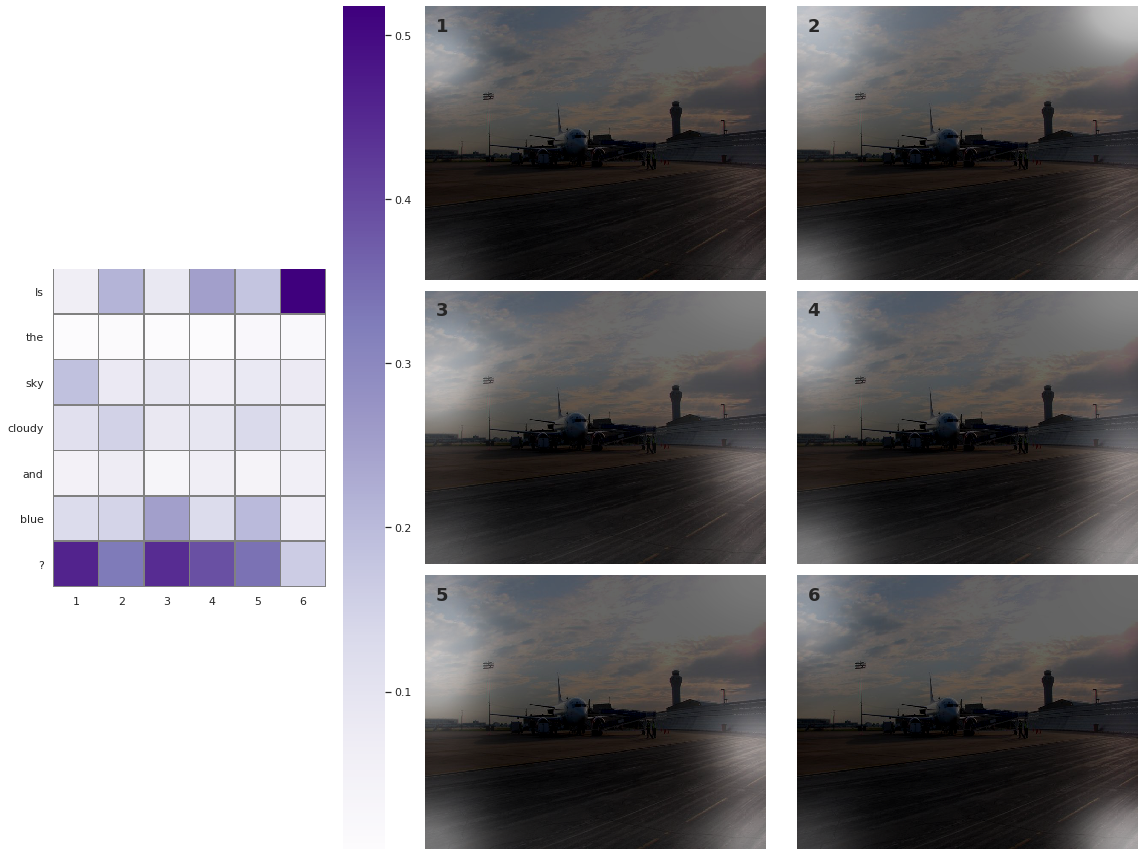

RESP yes
REAL yes


In [181]:
q_index = 121488
b = collate_fn_gqa([ds[q_index]])
with torch.no_grad():
    mid_outputs, output = mid_getter(b['image'], b['question'], b['question_length'])

plot_word_img_attn(mid_outputs, q_index, split, ds, num_steps=__C.model.max_step)
print('RESP', vocab['answer_idx_to_token'][output.argmax().item()])
print('REAL', vocab['answer_idx_to_token'][b['answer'][0].item()])

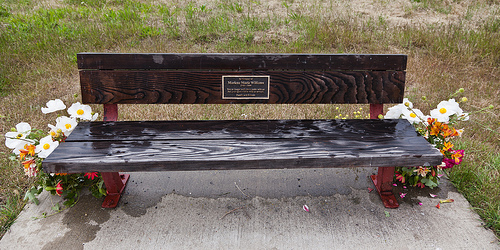

In [140]:
image_filename = '2374192' + '.jpg'
image = Image.open(os.path.join(__C.DATASET.DATA_DIR.strip('data'), 'images', image_filename)).convert('RGB')
image

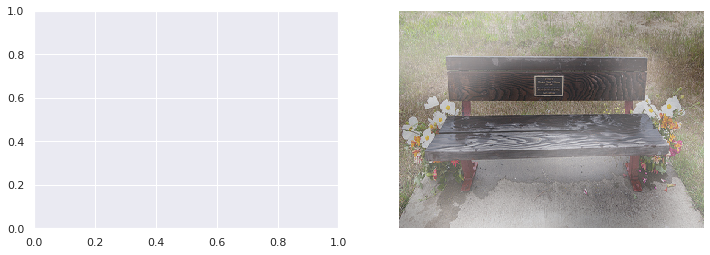

In [152]:
dx, dy = 0.05, 0.05
x = np.arange(-1.5, 1.5, dx)
y = np.arange(-1.0, 1.0, dy)
X, Y = np.meshgrid(x, y)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

ax = axes[1]

img1 = ax.imshow(image, interpolation="nearest", extent=extent)

ax.imshow(
    #np.array(atts[step]).reshape(imageDims),
    np.random.uniform(0, 1, (7, 7)),
          cmap=plt.get_cmap('custom'),
          interpolation="bicubic",
          extent=extent,

         )

ax.set_axis_off()
plt.axis("off")

ax.set_aspect("auto")